In [83]:
"""
importing the necessary libraries
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [84]:
"""
Reading the data
"""
df = pd.read_csv('CreditScoring.csv') 

#normalizing column names
df.columns = df.columns.str.lower()

In [85]:
"""
Checking first 5 rows 
"""
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [86]:
"""
Decoding categorical columns
"""

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [87]:
"""
Preparing numerical columns 
"""
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [88]:
"""
dropping rows where the status is unknown"
"""
df = df[df.status != 'unk'].reset_index(drop=True)

In [89]:
"""
Setting the target column to binary 
"""
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [90]:
"""
Splitting the data
"""
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.default
y_val = df_val.default
y_test = df_test.default

In [91]:
"""
Evaluating feature importance of numerical columns with auc score
"""
numerical = df.columns[df.dtypes != 'object']

for feature in numerical:
    auc_score = round(roc_auc_score(df_train['default'], df_train[feature]),2)
    if auc_score < 0.5:
        auc_score = round(roc_auc_score(df_train['default'], -df_train[feature]),2)
    print(feature+":", auc_score)

seniority: 0.71
time: 0.56
age: 0.57
expenses: 0.5
income: 0.68
assets: 0.65
debt: 0.5
amount: 0.59
price: 0.5
default: 1.0


The numerical feature with the highest auc score is 'seniority'

In [92]:
"""
creating training and validation data with selected columns 
"""
columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']
train_slice_df = df_train[columns]
val_slice_df = df_val[columns]

In [93]:
"""
Training and evaluating a logistic regression  model with auc
"""
#DictVectorizer performs one hot enconding on categorical columns
dv = DictVectorizer()

#creating an instance of the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

#convert train data to dictionary
train_slice_dict = train_slice_df.to_dict(orient='records')

#one hot encoding 
X_train = dv.fit_transform(train_slice_dict)

#specifying target values
y_train = df_train['default'].values

#Training the model 
model.fit(X_train, y_train)

#convert validation data to dictionary
val_slice_dict = val_slice_df.to_dict(orient='records')

#one hot encoding 
X_val = dv.transform(val_slice_dict)

y_val = df_val['default'].values

#model predictions for the validation data
y_pred = model.predict_proba(X_val)[:,1]

#cchecking model performance with auc score
roc_auc_score(y_val, y_pred)


0.8120879813449298

In [94]:
scores = []
def find_scores(y_val, y_pred, t):
    """
    This function computes precision and recall for various tresholds of a model,
    and appends computed scores to a list
    params:original values, predicted values, thresholds
    returns: list t, precison, recall
    rtype:pandas dataframe
    """
    tp = ((y_pred >= t ) & (y_val == 1)).sum()
    fp = ((y_pred >= t ) & (y_val == 0)).sum()
    tn = ((y_pred < t ) & (y_val == 0)).sum()
    fn = ((y_pred < t ) & (y_val == 1)).sum()
    
    # precision = tp / (tp + fp)
    # recall = tp / (tp + fn)       
    
    scores.append((t,tp, tn, fp, fn))    

In [95]:
"""
Evaluating precision and recall for specific thresholds,
and creating a dataframe with computed values
"""
thresholds = np.arange(0.0, 1.0, 0.01)

for t in thresholds:
     find_scores(y_val, y_pred, t)

df_scores = pd.DataFrame(scores, columns=(['t', 'tp', 'tn','fp', 'fn'])) 

#calculating precision and recall
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp) 
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn) 

Text(0.5, 0, 'Threshold')

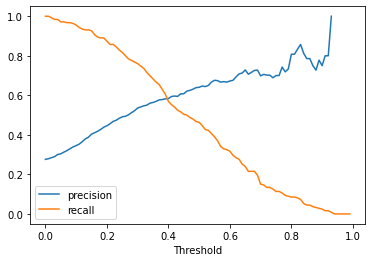

In [96]:
"""
Plotting precision and recall
"""
plt.plot(df_scores.t, df_scores.p, label='precision')
plt.plot(df_scores.t, df_scores.r, label='recall')
plt.legend()
plt.xlabel('Threshold')

precision and recall intersect at a treshold of 0.4

In [97]:
"""
Computing f1 score for all thresholds
"""
df_scores['f1'] = (2 * df_scores['p'] * df_scores['r']) / (df_scores['p'] + df_scores['r'])

In [105]:
"""
Checking the treshold with the highest f1 score
"""

df_scores.iloc[df_scores.f1.argmax()]

t       0.300000
tp    187.000000
tn    483.000000
fp    162.000000
fn     59.000000
p       0.535817
r       0.760163
f1      0.628571
Name: 30, dtype: float64

The treshold with the highest f1 score is 0.3

In [110]:
"""
Evaluating model using KFold
"""
from sklearn.model_selection import KFold

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
dv = DictVectorizer(sparse=False)

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    y_train = df_train.default.values
    train_dict = df_train[columns].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    model.fit(X_train, y_train)
    
    df_val = df_full_train.iloc[val_idx]
    y_val = df_val.default.values
    val_dict = df_val[columns].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

#prnting the mean auc score and standard deviation for all folds
print("mean: %.3f std: %.3f" % (np.mean(scores), np.std(scores)))

mean: 0.814 std: 0.015


In [107]:
"""
Evaluating model using different tuning paramteters
"""
from sklearn.model_selection import KFold

for C in [0.01, 0.1, 1, 10]:    

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    dv = DictVectorizer(sparse=False)

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        y_train = df_train.default.values
        train_dict = df_train[columns].to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
        model.fit(X_train, y_train)

        df_val = df_full_train.iloc[val_idx]
        y_val = df_val.default.values
        val_dict = df_val[columns].to_dict(orient='records')
        X_val = dv.transform(val_dict)
        y_pred = model.predict_proba(X_val)[:,1]

        score = roc_auc_score(y_val, y_pred)
        scores.append(score)

    print("%s %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

0.01 0.808 +- 0.012
0.1 0.813 +- 0.014
1 0.814 +- 0.015
10 0.814 +- 0.015


The C value that leads to the best score is: 1.0